# Notebook 1: Introduction with Shallow Water - Williamson 2 Test Case

This notebook provides an introduction to Gusto. We will go through the example of the Williamson 2 test case to demonstrate how to set up the problem and run it. This is the second test from the Williamson et al (1992) paper, which can be found at: 
https://doi.org/10.1016/S0021-9991(05)80016-6.

The Williamson 2 test case solves the shallow water equations. This corresponds to the following set of equations for a velocity, $\textbf{u}$, and fluid depth, $D$:
\begin{align}
\textbf{u}_t + (\textbf{u} \cdot \nabla) \textbf{u} + f \textbf{u}^{\perp} + g \nabla (D + b)  &= 0, \\
D_t + \nabla \cdot (D \textbf{u}) &= 0,
\end{align}

where $f$ is the Coriolis parameter, $g$ is the gravitational acceleration, and $D = H+h-b$ is the total depth of the fluid where $H$ is the mean fluid depth, $h$ is the free surface height and $b$ is the topography. No boundary conditions are required as in this case we are solving on a spherical domain.

The second Williamson test case models zonal geostrophic flow. This is a steady-state solution of the shallow-water equations, so the true solution does not change with time.

We begin by importing the required libraries and functions from Firedrake and Gusto. This step is required when starting any Gusto script.

In [1]:
from gusto import *
from firedrake import IcosahedralSphereMesh, SpatialCoordinate, as_vector, pi

We now define the time-step size, `dt`, and duration of the simulation, `tmax`.

In [2]:
dt = 4000.          # timestep (in seconds)
tmax = 20*dt        # duration of the simulation (in seconds)

The shallow water equations contain three parameters that need to be specified: the Coriolis parameter $f=2\Omega\sin\theta$ where $\Omega$ is the rotation rate and $\theta$ the latitude, the gravitational acceleration $g$ and the mean height of the fluid layer $H$. The `ShallowWaterParameters` class has Earth-sized values as default for both $\Omega$ and $g$ (`Omega=7.292e-5`$rad/s$ and `g=9.80616`$m/s^2$) meaning that we only need to specify $H$.

In [3]:
# setup shallow water parameters
H = 5960.
parameters = ShallowWaterParameters(H=H)

Next, we will construct a mesh of our domain. We will use one of the spherical meshes provided by Firedrake: the `IcosahedralSphereMesh`. As the spherical domain we are solving over is the Earth we specify the radius as 6371220m. The refinement level, `ref_level`, specifies the number of times the base icosahedron is refined, with each refinement dividing each triangular face in to 4 triangles. The argument `degree` specifies the polynomial degree of the function space used to represent the coordinates. Since this is a two dimensional mesh embedded in a three dimensional space, we have to specify the outward direction - this is what `mesh.init_cell_orientations` is doing.

In [4]:
# Set up the mesh and choose the refinement level
ref_level = 3  # number of horizontal cells = 20*(4^refinements)
R = 6371220.
mesh = IcosahedralSphereMesh(radius=R, refinement_level=ref_level, degree=3)
x = SpatialCoordinate(mesh)
mesh.init_cell_orientations(x)

We need to specify instructions regarding the output using the `OutputParameters` class. The directory name, `dirname`, must be specified before running the code. To prevent losing hard-earned simulation data, Gusto will not allow an existing file to be overwritten. Hence, if one wishes to re-run a simulation with the same output filename, the existing results file needs to be moved or deleted first. We also specify `dumpfreq`, as set earlier, otherwise this defaults to `dumpfreq=1` which would output vtus files at every timestep (very useful when first setting up a problem!). Since this flow should be in a steady state, it is also instructive to output the `steady_state_error_fields` for both $\textbf{u}$ and $D$ as this will tell us how close the simulation is to being correct. They will not be identically zero, due to numerical discretisation error, but the errors should not grow in time and they should reduce as the mesh and timestep are refined.

In [5]:
output = OutputParameters(dirname="williamson_2", steady_state_error_fields=['u', 'D'], log_level='INFO')

We can specify which diagnostics to record over a simulation. The list of avaliable diagnostics can be found in the gusto source code: https://github.com/firedrakeproject/gusto/blob/main/gusto/diagnostics.py. We pass these diagnostics into the `State` class, which controls the input and output and stores the fields which will be updated at each timestep.

In [6]:
diagnostic_fields = [RelativeVorticity(), PotentialVorticity(),
                     ShallowWaterKineticEnergy(),
                     ShallowWaterPotentialEnergy(),
                     ShallowWaterPotentialEnstrophy(),
                     CourantNumber()]

state = State(mesh,
              dt=dt,
              output=output,
              parameters=parameters,
              diagnostic_fields=diagnostic_fields)

gusto:INFO Physical parameters that take non-default values:
gusto:INFO H: 5960.0


Gusto will set up compatible finite element function spaces for the prognostic fields. These are uniquely defined by specifying the family (in this case `BDM`) of the HDiv space (used for the velocity $\textbf{u}$) and the degree (in this case `1`) of the DG space (used for the fluid depth $D$). As this test case is for a rotating sphere, we also define a spatially varying Coriolis force. We can then set up the finite element form of the shallow water equations by passing `state`, the HDiv family, the degree of the DG space, and the expression for the Coriolis parameter into the `ShallowWaterEquations` class. 

In [7]:
# Create a spatially varying function for the Coriolis force:
Omega = parameters.Omega
x = SpatialCoordinate(mesh)
fexpr = 2*Omega*x[2]/R
eqns = ShallowWaterEquations(state, "BDM", 1, fexpr=fexpr)

We are now ready to specify the initial conditions:
\begin{align}
\textbf{u}_0 &= \frac{u_{max}}{R} [-y,x,0], \\
D_0 &= H - \frac{\Omega u_{max} z^2}{g R}.
\end{align}
Due to our choice of function spaces for the velocity and depth, the initialisations of each variable use projection and interpolation operations respectively. 

In [14]:
u0 = state.fields("u")
D0 = state.fields("D")
day = 24*60*60
u_max = 2*pi*R/(12*day)  # Maximum amplitude of the zonal wind (m/s)
uexpr = as_vector([-u_max*x[1]/R, u_max*x[0]/R, 0.0])
g = parameters.g
Dexpr = H - ((R * Omega * u_max)*(x[2]*x[2]/(R*R)))/g
u0.project(uexpr)
D0.interpolate(Dexpr)

Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x1191c1100>, FiniteElement('Discontinuous Lagrange', triangle, 1), name='DG1', index=1, component=None), Mesh(VectorElement(FiniteElement('Lagrange', Cell('triangle', 3), 3), dim=3), 4)), 28)

Now we will choose a timestepper. One option is to use the `SemiImplicitQuasiNewton` approach. This approach splits the equation into 'transport' terms and 'forcing' terms (i.e. everything that's not transport) and solves each separately. This allows for different time-steppers to be used for transporting the velocity and depth fields. We choose to use an Implicit Midpoint method for the velocity and an explicit strong stability preserving RK3 (SSPRK3) method for the depth. Since the Courant number for a stable SSPRK3 scheme is lower than that for the Implicit Midpoint method, we do 2 subcycles of the SSPRK3 scheme per timestep, allowing us to use a longer timestep overall. A full list of avaliable time stepping methods can be found at: https://github.com/firedrakeproject/gusto/blob/main/gusto/time_discretisation.py.

In [15]:
transport_schemes = [ImplicitMidpoint(state, "u"),
                     SSPRK3(state, "D", subcycles=2)]
stepper = SemiImplicitQuasiNewton(eqns, state, transport_schemes)

In [17]:
# Run the timestepper and generate the output.
stepper.run(t=0, tmax=tmax)

/Users/JS1075/firedrake/src/firedrake/firedrake/checkpointing.py:89: DeprecationWarning: DumbCheckpoint class will be deprecated after 01/01/2023; use CheckpointFile class instead.
  warnings.warn("DumbCheckpoint class will be deprecated after 01/01/2023; use CheckpointFile class instead.",
gusto:INFO at start of timestep, t=0.0, dt=4000.0
gusto:INFO at start of timestep, t=4000.0, dt=4000.0
gusto:INFO at start of timestep, t=8000.0, dt=4000.0
gusto:INFO at start of timestep, t=12000.0, dt=4000.0
gusto:INFO at start of timestep, t=16000.0, dt=4000.0
gusto:INFO at start of timestep, t=20000.0, dt=4000.0
gusto:INFO at start of timestep, t=24000.0, dt=4000.0
gusto:INFO at start of timestep, t=28000.0, dt=4000.0
gusto:INFO at start of timestep, t=32000.0, dt=4000.0
gusto:INFO at start of timestep, t=36000.0, dt=4000.0
gusto:INFO at start of timestep, t=40000.0, dt=4000.0
gusto:INFO at start of timestep, t=44000.0, dt=4000.0
gusto:INFO at start of timestep, t=48000.0, dt=4000.0
gusto:INFO a

Another option is to use a single timestepping scheme to solve the full equation set. In this case, choosing to use RK4, the setup is:

In [11]:
RK_stepper = Timestepper(eqns, RK4(state), state)

In [18]:
import matplotlib.pyplot as plt
from matplotlib import cm
from firedrake import trisurf

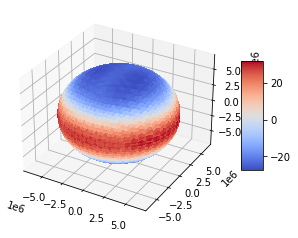

In [19]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ts=trisurf(state.fields('D_error'), axes=ax, cmap=cm.coolwarm)
fig.colorbar(ts, shrink=0.5, aspect=5)
plt.show()

We are ready to run our simulation! We simply instruct the time-stepper to run for the specified duration.

After the simulation is completed, you should see that there is now a 'results' directory, with a sub-directory containing the output of this simulation. The output at the specified times is saved in a .vtu format that can be viewed using Paraview. There are five files, corresponding to the specified dump times (field_output_1.vtu, field_output_2.vtu, .., field_output_5.vtu), as well as one for the initial conditions (field_output_0.vtu). Paraview can be downloaded from the following link: https://www.paraview.org/.

This test case should generate a steady state solution. Plotting these results in Paraview should give velocity and height fields that don't appear to change at each output time. The desired output from Gusto is visualised below.

Velocity magnitude:
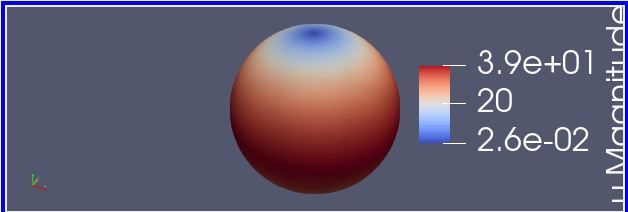

Depth field:
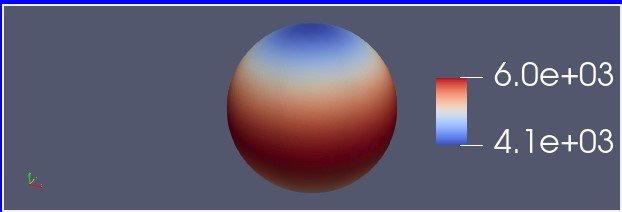

Congratulations, you have now successfully run a Gusto script!